In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis, skew
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm import tqdm_notebook as tqdm
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
# import nct
import bct
import pandas as pd

import pickle 
import _pickle as cPickle
import gzip

def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f,encoding="bytes") #change this for python 2
        return loaded_object
    
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [3]:
#Define Save Location
saveLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Network Comparison/'
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'
saveResults='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/'

In [4]:
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]#np.linspace(0,10,201)

In [5]:
def getNLT(Graph=[],electrodes=[],amp=2,nwType=[]):
    stimulus=[[],[]]
    dt = 1e-3
    f=0.5
    Time=5
    
    ampName=str(amp).replace('.','p')
    dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/'+nwType+' Results/'

    stimulus[0].append((stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,Time,dt),f=f)))
    stimulus[1].append((stimulus__(biasType='Drain',TimeVector=np.arange(0,Time,dt)))) #we don't want this drain to be active during training

    stimulus2 = [item for item in stimulus] #go through each list in the list and find the ith item

    results_minMax=runSim(connectivity__(graph=Graph),stimulus=stimulus2, contactMode='preSet',electrodes=electrodes, T = Time, dt = dt, onAmp = amp, biasType='AC',f=f,junctionMode='tunneling',findFirst=False)
    results={'JunctionConductance':results_minMax.junctionConductance,'JunctionVoltage':results_minMax.junctionVoltage,'Switch':results_minMax.junctionSwitch,'Source':results_minMax.sources[0:2],'Drain':results_minMax.drains[0:2],'Signal':results_minMax.stimulus,'conductance':results_minMax.conductance}
    compressed_pickle(results,dataLoc+'_NLT_Simulation_'+'_'+nwType+'Networks_SamePathLength'+ampName+'v.pkl')

    if len(Graph) >= 250:
    #         nodesList=[50,100,150,200,250,len(ASN300[Max_Min_NWS[j][0]][Max_Min_NWS[j][1]]['G'])]#range(50, len(ws300[i][0])+1,50)
        nodesList=[len(Graph)]#only want all nodes
    elif len(Graph) >= 200 and len(Graph) < 250:
        nodesList=[len(Graph)]
    elif len(Graph) >= 150 and len(Graph) < 200:
        nodesList=[len(Graph)] 
    elif len(Graph) >= 100 and len(Graph) < 150:
        nodesList=[len(Graph)]

    nwSqu =[None]*len(nodesList)

    countK=0
    for k in nodesList: #loop through sets of nodes for regression
        print('Running Regression: ' + str(k) + ' nodes')
        ResultSqu=[]
        ResultSqu = nonLinearTrans(results_minMax,'Square',k, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
        nwSqu[countK]=ResultSqu['accuracy']
        countK=countK+1
    return nwSqu

In [6]:
def get_MC_Voltsweep(Graph=[],electrodes=[],amp = 2,nwType=[], dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/'+nwType+' Results/'


    signal = signal_expand(np.random.random(1000)*2*amp-amp, dur)
    results_minMax = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                start_state =  init_state,
                biasType = 'Custom', customSignal = signal, 
                junctionMode = 'tunneling', 
                contactMode = 'preSet',
                electrodes=electrodes,
                findFirst=False, disable_tqdm=True)
    
    results={'JunctionConductance':results_minMax.junctionConductance[-1],'JunctionVoltage':results_minMax.junctionVoltage[-1],'Switch':results_minMax.junctionSwitch[-1],'Source':results_minMax.sources[0:2],'Drain':results_minMax.drains[0:2],'Signal':results_minMax.stimulus,'conductance':results_minMax.conductance}
    compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_'+nwType+'Networks_SamePathLength'+ampName+'v.pkl')
    
    n_outs=len(Graph)
    mcRAND = [MC_k(results_minMax, k, n_outs = n_outs) for k in range(dur, len(Graph)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), results_minMax
    else:
        return np.sum(mcRAND)

In [7]:
name='/import/silo2/aloe8475/Documents/CODE/Analysis/Functional Connectivity/Functional Tasks/VaryingDensity300NWset2_NWN.pkl'
file = open(name, 'rb')
[NWN] = pickle.load(file)
Modular=False

In [8]:
if not Modular:
    networks=[]
    for i in range(len(NWN)):
        for j in range(len(NWN[i])):
            networks.append(NWN[i][j])

In [9]:
if not Modular:
    G=[]
    for i in tqdm(range(len(networks))):
        G.append(nx.from_numpy_array(networks[i]['adj_matrix']))

In [10]:
if Modular:
    nwnGraph=G#[97] #network with ~same avg degree as c elegans
else:
    nwnGraph=G[97]
nwnAvgDeg=np.mean([val for (node,val) in nwnGraph.degree()])
nwnEdges=nwnGraph.number_of_edges()
nwnNodes=nwnGraph.number_of_nodes()

In [11]:
OG=nwnGraph.copy()

In [12]:
erWiredGraph=nx.double_edge_swap(OG,nswap=50000,max_tries=500000,seed=10)
erWiredGraph.remove_edges_from(list(nx.selfloop_edges(erWiredGraph)))
erWiredGraph=max(connected_component_subgraphs(erWiredGraph), key=len)
adjMat2=nx.adjacency_matrix(erWiredGraph)

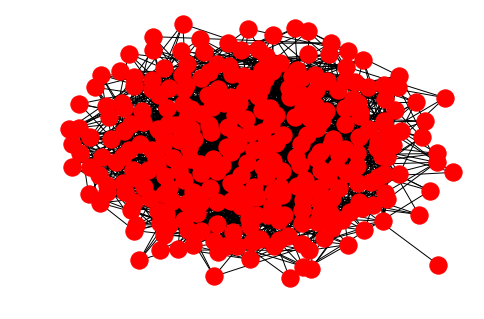

In [13]:
pos=nx.kamada_kawai_layout(erWiredGraph)
nx.draw(erWiredGraph,pos=pos)


In [14]:
nx.diameter(erWiredGraph)

4

In [15]:
#Choose Electrodes to make sure path length distance is the same

electrodes=[48,238]

In [16]:
len(nx.bidirectional_shortest_path(nwnGraph,48,238))

4

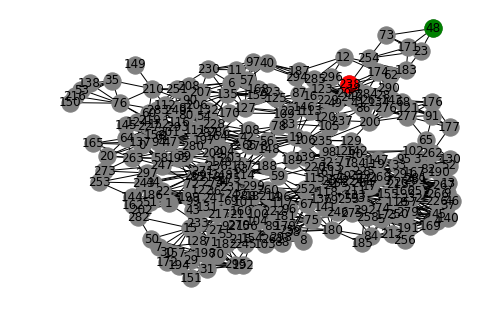

In [17]:
pos=nx.kamada_kawai_layout(nwnGraph)
nx.draw(nwnGraph,pos=pos,node_color='grey',with_labels=True)
nx.draw_networkx_nodes(nwnGraph,pos=pos,nodelist=[electrodes[0]],node_color='g')
nx.draw_networkx_nodes(nwnGraph,pos=pos,nodelist=[electrodes[1]],node_color='r')

In [20]:
resultNWN=[]
for amp in tqdm(onAmp):
    resultNWN.append(getNLT(Graph=nwnGraph,electrodes=electrodes,amp=amp,nwType='NWN'))

Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes


Running Regression: 300 nodes



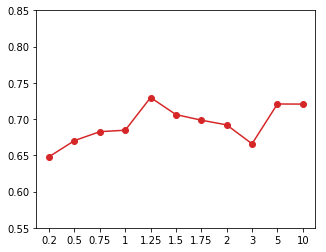

In [23]:
fig,ax=plt.subplots(1,figsize=(5,4))
ax.plot(resultNWN,'-o',color='tab:red')
ax.set_ylim([0.55,0.85])
ax.set_xticks(np.arange(0,len(onAmp)))
ax.set_xticklabels(onAmp)
plt.savefig(saveFig+'NWN Path Length Source to Drain Same as NWN Rewired.png')

In [18]:
voltNames=['0p2','0p5','0p75','1','1p25','1p5','1p75','2','3','5','10']

In [21]:
dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/NWN Results/'

NWN_NLT_sims=[]
NWN_MC_sims=[]
for volt in tqdm(range(len(resultNWN))):
    name=dataLoc+'_NLT_Simulation_'+'_NWNNetworks_SamePathLength'+voltNames[volt]+'v.pkl'
#     name2=dataLoc+'_MC_Simulation_'+'_NWNNetworks_SamePathLength'+voltNames[volt]+'v.pkl'
    NWN_NLT_sims.append(decompress_pickle(name))
#     NWN_MC_sims.append(decompress_pickle(name2))

In [22]:
def getWeightedGraph(sims,network,edgeList,numWires):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = sims['JunctionConductance'][-1]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = sims['JunctionConductance'][-1]#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

In [24]:
sources=[]
drains=[]
sourcesMC=[]
drainsMC=[] 
weightedSubGraph_NLT=[] 
weightedSubGraph_MC=[] 
for j in range(len(resultNWN)):
        sim=NWN_NLT_sims[j]
        graph=nwnGraph
        network=np.array(nx.adjacency_matrix(graph).todense())

        sources.append(sim['Source'])
        drains.append(sim['Drain'])
        OGgraph=graph
        pos=nx.kamada_kawai_layout(OGgraph)
        numWires=graph.number_of_nodes()
        sim['JunctionResistance']=1/sim['JunctionConductance'][-1]
        edgeList=np.array(list(graph.edges()))
#         subGraph=getOnGraph(sim,network,edgeList,numWires)
        weightedSubGraph_NLT.append(getWeightedGraph(sim,network,edgeList,numWires))

In [25]:
for i in range(len(weightedSubGraph_NLT)):
    weights=[]
    weightsMin=[]
    maxNW=np.argmax(resultNWN[i])
    minNW=np.argmin(resultNWN[i])
    G=weightedSubGraph_NLT[i]
    edges=G.edges()
    weights1=[G[u][v]['weight'] for u,v in edges]
    weights.append([j * 1e6 for i in (weights1)])

# minWeightsNLT=np.min(minWeightsNLT)
# maxWeightsNLT=np.max(maxWeightsNLT)

In [26]:
import matplotlib.colors as clrs

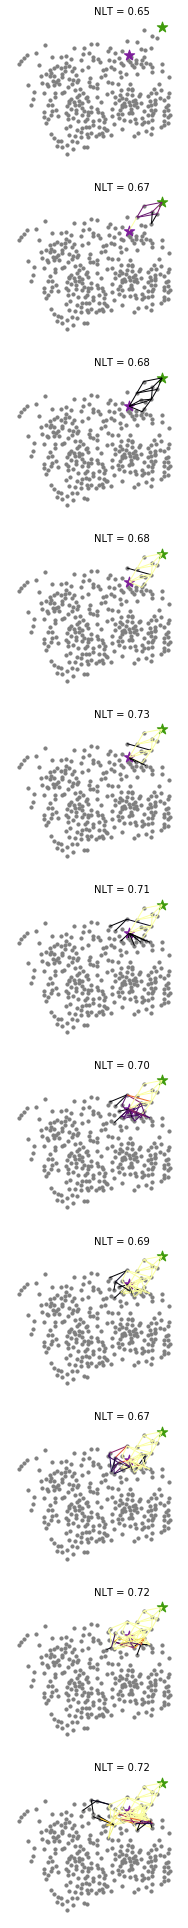

In [28]:
fig, axes = plt.subplots(11,1,figsize=(3,35))
for j in range(len(weightedSubGraph_NLT)):
        #find top + bottom network
    ax=axes[j]
    G=weightedSubGraph_NLT[j]#current_new[i][j][maxNW]
    edge_weights=nx.get_edge_attributes(G,'weight')
    G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-6)) #why did we choose 1e-6
    edges=G.edges()
#         set_trace()
    weights=[G[u][v]['weight'] for u,v in edges]
#         weights=[w * 1e6 for w in (weights)]
#         cNorm=clrs.SymLogNorm(10,vmin=minWeightsNLT,vmax=maxWeightsNLT)
#         scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=plt.cm.inferno)
#         colorList=[]
#         for k in range(len(weights)):
#             colorVal = scalarMap.to_rgba(weights[k])
#             colorList.append(colorVal)

    OGgraph=nwnGraph
    #draw OG graph
    pos=nx.kamada_kawai_layout(OGgraph)
    h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
    h.set_zorder(1)

    if i == 0:
        ax.set_ylabel(str(onAmp[j])+'V')
    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.inferno,edge_vmin=np.min(np.array(weights1)),edge_vmax=np.max(np.array(weights1)))

    if h2:
        h2.set_norm(clrs.SymLogNorm(10))
        h2.set_zorder(3)
#             if j == 10 and i == 6:
#                 plt.colorbar(h2)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=[sources[j][0]],node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=[drains[j][0]],node_color='#7e1e9c',node_size=120,node_shape ='*',ax=ax)
    ax.set_frame_on(False)

    ax.annotate('NLT = '+"{0:.2f}".format(resultNWN[j][0]),xy=(0.5,1),xycoords='axes fraction')
    ax.set_yticks([])
    ax.set_xticks([])
plt.savefig(saveFig+'VSweep 300NWN Path Length Source to Drain Same as NWN Rewired - Current + Threshold Weighted Graphs NLT.pdf',format='pdf',dpi=300)